In [1]:
# Import modules
import pandas as pd
import numpy as np
import dataframe_image as dfi
import matplotlib.pyplot as plt
import time
import ssl
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [2]:
# Instantiate headers and cookies
headers = {'User-Agent': 'Mozilla/5.0',
'cookie': 'split.rkSplit=false; countryFrom=kz; project=68; _ga=GA1.2.809907238.1551132602;'
          '_ym_uid=1551132602418148161; _ym_d=1551132602; _2gis_webapi_session=7b3a262e-3de3-4d68-92da-7c2f54752ced; '
          '_2gis_webapi_user=412ec892-87a6-4bc6-9b11-b3ec982933f3; socialRefererSet=1; _gid=GA1.2.2117315879.1551816480; '
          'regionsHash=a5ceb3915d34ded7ef8e1295d4d1b430; _ym_isad=1; '
          'ipp_key=v1551868467964%2Fv3394bde41e540e2206ba54163aeca6afa04ab3%2FJ9QfGc%2fX85cnC5yw80L6eg%3d%3d; '
          'ipp_uid=1551868467963%2fRifwXqSRLKAk4cl1%2fhjKqVc9ZndV5Swv6RbTT8g%3d%3d; ipp_uid1=1551868467963; '
          'ipp_uid2=RifwXqSRLKAk4cl1%2fhjKqVc9ZndV5Swv6RbTT8g%3d%3d; ipp_uid_tst=; ipp_static_key=; _2gis_wsize=734x1002'}

In [3]:
# Instantiate a web-browser
chrome_options = webdriver.ChromeOptions()
prefs = {"profile.managed_default_content_settings.images": 2}
chrome_options.add_experimental_option("prefs", prefs)
driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=chrome_options)

In [4]:
# Create containers
names = []
place_type = []
street = []
avg_check = []

# Open the web-site
url = "https://2gis.kz/almaty/search/%D0%9F%D0%BE%D0%B5%D1%81%D1%82%D1%8C/page/"
driver.get(url)

## Scrape the data
try:
    for p in range(2,400):
        link = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.LINK_TEXT, str(p))))
    #     link = driver.find_element_by_link_text(str(p))
        driver.execute_script("arguments[0].click();", link)
        time.sleep(5)
        soup = BeautifulSoup(driver.page_source, "html.parser")

        # add average check
        for i in soup.findAll("div", {"class":['_127a00i']}):
            avg_check += [i.text.split('.')[0]]

        # add street address
        for i in soup.findAll("span", {"class":['_tluih8']}):
            street += [i.text]

        # add name
        for n in soup.findAll("span", {"class":["_hc69qa", "_6vzrncr"]}):
            names += [n.text]

        # add place type
        for i in soup.findAll("span", {"class":['_oqoid']}):
            place_type += [i.text]
except:
    pass

# save to the Pandas dataframe
df = pd.DataFrame(list(zip(names, place_type,  avg_check, street)),
                   columns=['Название', 'Тип заведения', 'Средний чек', 'Адресс'])    

# export dataset as csv-file
df.to_csv('restaurants.csv')

In [5]:
# Glimpse at the dataset
rest = pd.read_csv('restaurants.csv')
rest.head()

,Название,Тип заведения,Средний чек,Адресс
0,Gold,комплекс,Средний чек 3000 тнг,"микрорайон Жетысу-2, 11"
1,Таверна на углях,кафе,Средний чек 3500 тнг,"Розыбакиева, 109"
2,SATORI,ресторан,Средний чек 5000 тнг,"Маметовой, 25"
3,Додо Пицца,сеть пиццерий,Средний чек 2000 тнг,"Кунаева, 41"
4,Ladurée,ресторан,Средний чек 10000 тнг,"ЖК Еsentai Apartments, проспект Аль-Фараби, 77/3"


In [6]:
# Delete of row which does not contain "Средний чек"
rest.loc[~rest['Средний чек'].str.contains('Средний чек', na=False), 'Средний чек'] = np.nan

In [7]:
# Drop all null values
rest = rest.dropna().reset_index(drop=True)

In [8]:
# Rename some words 
rest = rest.replace(regex={'Средний чек ':'', ' тнг':'', 'сеть ':'', 'кофеен':'кофейня', ' быстрого питания':'',
                          'Быстрое питание':'кафе', 'суши-баров': 'суши-бар'})

In [9]:
# Convert 'Средний чек' to numeric value
rest['Средний чек'] = pd.to_numeric(rest['Средний чек'])

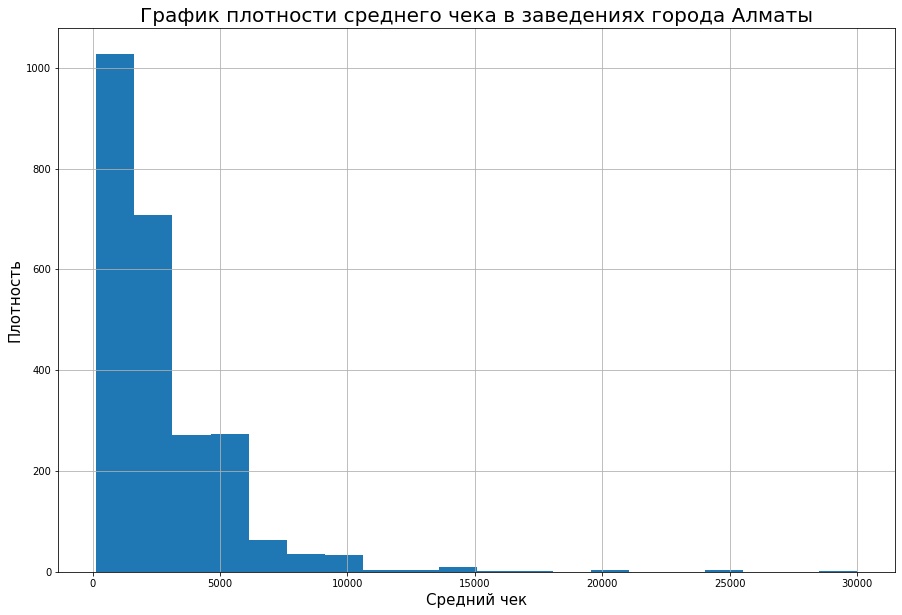

In [10]:
# Buind a histogram of avg check distribution
plt.figure(figsize=[15,10])
rest['Средний чек'].hist(bins=20)
plt.xlabel('Средний чек', fontsize=15)
plt.ylabel('Плотность', fontsize=15)
plt.title('График плотности среднего чека в заведениях города Алматы',fontsize=20)
plt.savefig('..//almaty_rest/images/График плотности среднего чека в заведениях города Алматы.jpeg', bbox_inches='tight')
plt.show()

In [11]:
# Top-20 'Название' with the highest number and their avg check
top_res = rest.groupby('Название').agg(['count','mean'])
top_res.columns = top_res.columns.droplevel()
top_res = top_res.sort_values(by='count', ascending=False).round(2).rename({'count':'Кол-во', 'mean':'Средний чек (тнг)'}, axis=1)
dfi.export(top_res.head(20), '..//almaty_rest/images/Top-20 restaurants.jpeg')
top_res.head(20)

,Кол-во,Средний чек (тнг)
Название,,
Столовая,35,1082.86
KFC,23,1230.87
Gippo,23,700.00
Degirmen,22,1381.82
Кафе,11,1172.73
Lanzhou,10,1250.00
Додо Пицца,10,2100.00
McDonald`s,10,1500.00
Burger King,10,1840.00


In [12]:
# convert all words to the lower case in 'Тип заведения'
rest['Тип заведения'] = rest['Тип заведения'].str.lower()

In [13]:
# count values of each 'Тип заведения'
rest['Тип заведения'].value_counts().head(30)

кафе                                 815
кофейня                              220
ресторан                             218
столовая                             172
ресторанов                            45
столовые                              41
киоск                                 36
пиццерия                              29
комплекс                              29
гостиничный комплекс                  29
суши-бар                              29
лаундж-бар                            29
ресторанный комплекс                  28
ресто-бар                             27
бар                                   26
лагманхана                            26
кафе-бар                              26
предприятие быстрого обслуживания     23
павильонов и кафе                     23
пиццерий                              20
экспресс-кофейня                      17
чайхана                               16
кафе и киосков                        13
семейное кафе                         11
шашлычная       

In [14]:
# rename all similar 'Тип заведения'
rest.loc[rest['Тип заведения'].str.contains('каф'), 'Тип заведения'] = 'кафе'
rest.loc[rest['Тип заведения'].str.contains('ресторан'), 'Тип заведения'] = 'ресторан'
rest.loc[rest['Тип заведения'].str.contains('столовые'), 'Тип заведения'] = 'столовая'

In [15]:
# count values of each 'Тип заведения' again
rest['Тип заведения'].value_counts().head(30)

кафе                                 1009
ресторан                              396
кофейня                               220
столовая                              213
киоск                                  36
лаундж-бар                             29
суши-бар                               29
комплекс                               29
гостиничный комплекс                   29
пиццерия                               29
ресто-бар                              27
бар                                    26
лагманхана                             26
предприятие быстрого обслуживания      23
пиццерий                               20
экспресс-кофейня                       17
чайхана                                16
шашлычная                              10
бары                                    8
точка                                   8
киосков                                 6
кофейня-кондитерская                    6
гриль-бар                               6
столовых                          

In [16]:
# Top-10 food places with their avg check
top_type = rest.groupby('Тип заведения').agg(['count','mean'])
top_type.columns = top_type.columns.droplevel()
top_type = top_type.sort_values(by='count', ascending=False).round(2).rename({'count':'Кол-во', 'mean':'Средний чек (тнг)'}, axis=1)
dfi.export(top_type.head(20), '..//almaty_rest/images/Top-20 types.jpeg')
top_type.head(20)

,Кол-во,Средний чек (тнг)
Тип заведения,,
кафе,1009,2308.91
ресторан,396,5463.38
кофейня,220,1681.90
столовая,213,1124.13
киоск,36,1298.61
пиццерия,29,2266.90
комплекс,29,2803.45
гостиничный комплекс,29,4234.48
лаундж-бар,29,4431.03


In [17]:
pd.Series(top_type['Кол-во'].sum() - top_type['Кол-во'].head(4).sum(), index=['другие'])
type_count = top_type['Кол-во'].head(4).append(pd.Series(top_type['Кол-во'].sum() - top_type['Кол-во'].head(4).sum(), index=['другие']))

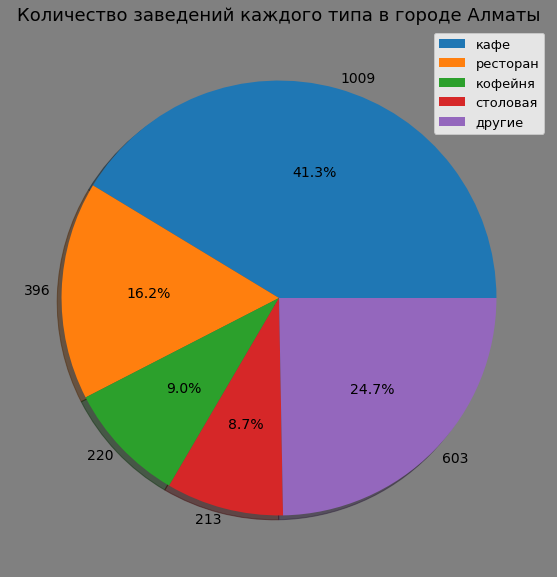

In [18]:
fig1, ax1 = plt.subplots(figsize=(15,10), facecolor='grey')
ax1.pie(type_count, labels=type_count.values, labeldistance=1.05, autopct='%1.1f%%', 
        shadow=True, textprops={'fontsize': 14})
plt.legend(labels=type_count.index, loc='upper right', fontsize=13)
plt.title('Количество заведений каждого типа в городе Алматы', fontsize=18)
plt.savefig('..//almaty_rest/images/Количество заведений каждого типа в городе Алматы.jpeg', bbox_inches='tight')
plt.show()

In [19]:
# # Create containers
# names = []
# place_type = []
# street = []
# discrict = []
# rating = []
# schedule = []
# avg_check = []
# lat = []
# lon = []
# reviews = []

# # Scrape data from first page
# url = "https://2gis.kz/almaty/search/%D0%9F%D0%BE%D0%B5%D1%81%D1%82%D1%8C/page/"
# driver.get(url)

# request = Request(url, headers=headers)
# source = urlopen(request, context=ssl.SSLContext()).read()
# soup = BeautifulSoup(source, features="html.parser")


# for i in soup.findAll("span", {"class":["_hc69qa"]}):
#     names += [i.text]
# for i in soup.findAll("span", {"class":['_oqoid']}):
#     place_type += [i.text]
# for i in soup.findAll("div", {"class":['_127a00i']}):
#     avg_check += [i.text.split('.')[0]]
# for i in soup.findAll("span", {"class":['_tluih8']}):
#     street += [i.text]


# for j in name:
# #     link = driver.find_element_by_link_text(j)
#     link = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.LINK_TEXT, j)))
#     driver.execute_script("arguments[0].click();", link)
#     time.sleep(1)
#     try:
#         rating += [driver.find_element_by_class_name('_1n8h0vx').text]
#     except:
#         rating += [None]
#     try:
#         reviews += [driver.find_element_by_class_name('_gg5kmr').text]
#     except:
#         reviews += [0]
#     schedule += [driver.find_elements_by_class_name('_49kxlr')[2].text.split('\n')[0]]
#     discrict += [driver.find_elements_by_class_name('_1p8iqzw')[-1].text]
#     lat += [driver.current_url.split('%2C')[1]]
#     lon += [driver.current_url.split('%2C')[0].rsplit('/')[-1]]  


In [20]:
#         try:
#             rating += [driver.find_element_by_class_name('_1n8h0vx').text]
#         except:
#             rating += [np.nan]

#         discrict += [driver.find_elements_by_class_name('_1p8iqzw')[-1].text]
#         schedule += [driver.find_elements_by_class_name('_49kxlr')[2].text.split('\n')[0]]
#         try:
#             reviews += [driver.find_element_by_class_name('_gg5kmr').text]
#         except:
#             reviews += [0]
#         lat += [driver.current_url.split('%2C')[1]]
#         lon += [driver.current_url.split('%2C')[0].rsplit('/')[-1]]

In [21]:
# df = pd.DataFrame(list(zip(names, place_type, rating, reviews, schedule, avg_check, street, discrict, lat, lon)),
#                    columns=['Название', 'Тип заведения', 'Рейтинг', 'Кол-во отзывов','Режим работы', 'Средний чек', 'Улица', 'Район', 'Широта', 'Долгота'])